In [1]:
import sys

sys.path.append("/home/lamhung/code/xlsr-english-l2/ML-main/")
from scripts.eval.evaluate import evaluate
from scripts.core.ipa import simplify_ipa
from datasets import load_dataset
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

/home/lamhung/miniconda3/envs/default/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor_l2 = Wav2Vec2Processor.from_pretrained(
    "Lam-Hung/xlsr-english-l2",
    sampling_rate=16000
)

model_l2 = Wav2Vec2ForCTC.from_pretrained(
    "Lam-Hung/xlsr-english-l2"
).to(device)

In [4]:
dataset = load_dataset("KoelLabs/L2Arctic")["scripted"],  # type: ignore

In [5]:
dataset[0]

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code', 'speaker_gender', 'speaker_native_language'],
    num_rows: 3599
})

In [6]:
RANDOM_SEED = 42
split_dataset = dataset[0].train_test_split(test_size=0.2, seed=RANDOM_SEED) # type: ignore


In [7]:
split_dataset['train']

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code', 'speaker_gender', 'speaker_native_language'],
    num_rows: 2879
})

In [8]:
split_dataset['test']

Dataset({
    features: ['audio', 'ipa', 'text', 'speaker_code', 'speaker_gender', 'speaker_native_language'],
    num_rows: 720
})

In [ ]:
inputs = processor_l2(
    split_dataset['test'][0]['audio']['array'],
    sampling_rate=16000,
    return_tensors="pt"
)

# đưa input tensor lên GPU
input_values_l2 = inputs.input_values.to(device)

# inference trên GPU
with torch.no_grad():
    logits = model_l2(input_values_l2).logits

predicted_ids_l2 = torch.argmax(logits, dim=-1)
transcription_l2 = processor_l2.batch_decode(predicted_ids_l2)

transcription_l2

['deɪwɝθɹihʌndɹɪdjɑɹdsʌpɑɹt']

In [11]:
evaluate(transcription_l2, split_dataset['test'][0]["ipa"], simplify=True)  # type: ignore

(30.0, 0.0)

In [12]:
per, fer = [], []

In [13]:
# to cuda
for row in split_dataset['test']:
    inputs = processor_l2(
        row['audio']['array'],
        sampling_rate=16000,
        return_tensors="pt"
    )

    # đưa input tensor lên GPU
    input_values_l2 = inputs.input_values.to(device)

    # inference trên GPU
    with torch.no_grad():
        logits = model_l2(input_values_l2).logits

    predicted_ids_l2 = torch.argmax(logits, dim=-1)
    transcription_l2 = processor_l2.batch_decode(predicted_ids_l2)
    per_score, fer_score = evaluate(transcription_l2, row["ipa"], simplify=True)
    per.append(per_score)
    fer.append(fer_score)

In [14]:
# final PER and FER
print(f"Final PER: {sum(per)/len(per)}")
print(f"Final FER: {sum(fer)/len(fer)}")

Final PER: 42.28333333333333
Final FER: 0.018271501317770826


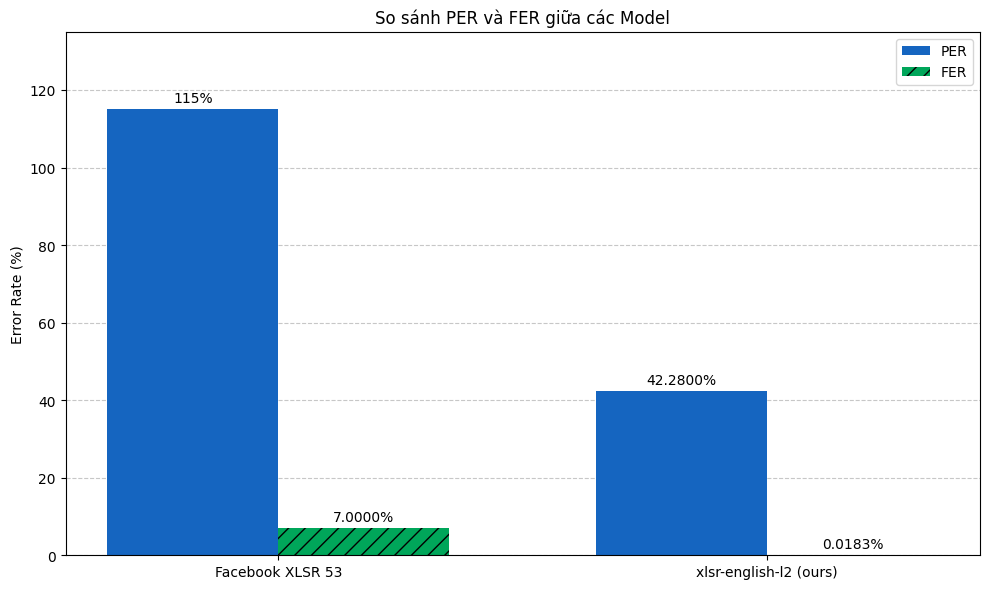

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


models = ['Facebook XLSR 53', 'xlsr-english-l2 (ours)']
per_values = [115, 42.28]
fer_values = [7, 0.0183]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, per_values, width, label='PER', color='#1565C0')

rects2 = ax.bar(x + width/2, fer_values, width, label='FER', color='#00A65A', hatch='//')

ax.set_ylabel('Error Rate (%)')
ax.set_title('So sánh PER và FER giữa các Model')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}%' if height < 100 else f'{int(height)}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylim(0, max(per_values) + 20)

plt.tight_layout()
plt.show()